In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy as sp
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import integrate
%pylab inline
import scipy.optimize as optimize
from scipy import optimize
from scipy.optimize import fmin, curve_fit
import pandas as pd
import numpy as np
import mpmath as mp
from mpmath import polylog
mp.dps = 15; mp.pretty = True

# matplotlib settings
#import matplotlib
#matplotlib.rcParams['text.usetex'] = True
#import matplotlib.pyplot as plt
#%matplotlib inline

import json

# Andrew's postprocessing tools
#import density_response as dr

# from Andrew's notebook
import seaborn as sns

# for PIMC UEG data
import matplotlib.pyplot as plt

from keras import losses
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Setting up some parameters

In [3]:
c = 137.0 # speed of light in atomic units
#d = 0.15 # FWHM of Gaussian pulse
# Atomic units
hbarSI = 1.0545718001391127E-34
meSI=9.10938356E-31
eSI=1.60217662E-19
eps0SI=8.8541878128E-12
Hartree2Joule = 4.35974417E-18
Hartree2eV = 27.2114
Joule2eV = 6.24151301951E+18
time2s = 2.418884326505E-17
SI_conversion_conductivity = 1.0/(2.17398e-7)
## Conversion of some units to a.u.
bohr2A = 0.52917721092
bohr2nm = 0.052917721092
hartree2eV = 27.211385
hartree2K = 3.15774641e5
Ngrid = 1000

# Helper functions

In [4]:
# Determine the q-value for a given angle and probe wavelength
def qval(theta,lambda0):
    # input: theta in angles, lambda0 in a.u. (bohr)
    # output: in a.u. (1/bohr)
    t1 = np.abs(4.0*np.pi*np.sin((theta* np.pi / 180.)/2.0)/lambda0)
    return t1

# Chemical potential of free electron gas

For example, see So2009 Equations (16.2.61) and (16.2.62).

In [5]:
def neFunc(mu,T,ne):
    result = ne+2.0*(T/(2.0*np.pi))**(3.0/2.0)*mp.fp.polylog(3.0/2.0,-1.0*np.exp(mu/T))
    return real(result)

In [6]:
def find_mu(T,ne):
    sol = sp.optimize.root( neFunc, x0=1.0, args=(T,ne) )
    print(sol)
    return sol.x

# Density-density response function

## Lindhard function

In [7]:
def ChiLind(q,omega,rs,mu,T,Ngrid,kmax):
    kF = (9.0*np.pi/4.0)**(1.0/3.0)/rs
    # Need to check convergence of integral wrt kmax and Ngrid
    # Arrays for k
    # be aware to check convergence of the integral over k at higher temperatures
    Ngrid_k = Ngrid
    ra_k = linspace(0.0,kmax,Ngrid_k)
    ra_kF = linspace(0.0,kmax,Ngrid_k)
    ek = 0.5*ra_k**2
    FD = 1.0/(np.exp((ek-mu)/T)+1.0)
    omegaqpp = omega + ra_k*q + 0.5*q**2
    omegaqpm = omega + ra_k*q - 0.5*q**2
    omegaqmp = omega - ra_k*q + 0.5*q**2
    omegaqmm = omega - ra_k*q - 0.5*q**2    
    chi = 1.0/(2*np.pi**2)*sp.integrate.trapz(FD*ra_k/q* \
        ( np.log(-2j*omegaqpm) \
         -np.log(-2j*omegaqmm) \
         +np.log(-2j*omegaqmp) \
         -np.log(-2j*omegaqpp) \
        ),ra_kF)
    return chi

## Static local field correction (from PIMC data of UEG)

In [8]:
# Define LFC
LR = LeakyReLU()
LR.__name__ = 'relu'

# Define the Keras model

N_LAYER = 40
W_LAYER = 64

model = Sequential()
model.add(Dense(W_LAYER, input_dim=3, activation=LR))

REGULARIZATION_RATE = 0.0000006

for i in range(N_LAYER-1):
	model.add( Dense( W_LAYER, activation=LR, kernel_regularizer=regularizers.l2( REGULARIZATION_RATE ) ) )

model.add(Dense(1, activation='linear'))

# Load the trained weights from hdf5 file
model.load_weights('LFC.h5')

# Define simple wrapper function (x=q/q_F):

def GPIMC(q,rs,theta):
    kF = (9.0*np.pi/4.0)**(1.0/3.0)/rs
    x = q/kF
    result = model.predict( np.array( [[x,rs,theta]] ) )
    return result[0][0]

/home/tommy/anaconda3/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


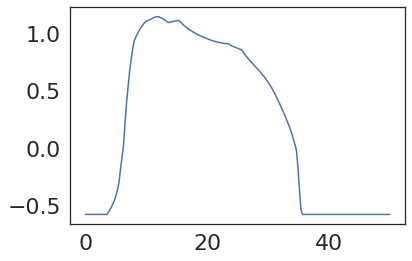

In [28]:
# plot static LFC
rs = 2.07 # from below
theta0 = 24 # from below
k = np.linspace(0, 50, 200)
plt.plot(k, [GPIMC(x, rs, theta0) for x in k])

In [9]:
def ChiGPIMC(q,omega,rs,mu,T,Ngrid,kmax):
    result = ChiLind(q,omega,rs,mu,T,Ngrid,kmax)/(1.0-4.0*np.pi/q**2*(1.0-GPIMC(q,rs,T))*ChiLind(q,omega,rs,mu,T,Ngrid,kmax))
    return result

# Dielectric function

## Define Lindhard dielectric function in term of the Lindhard function 

In [10]:
# Define Lindhard dielectric function in term of the Lindahrd function 
# From So2010, Equation (29.2.32)
def EpsLind(q,omega,rs,mu,T,Ngrid,kmax):
    t1 = 1.0-4.0*np.pi/q**2*ChiLind(q,omega,rs,mu,T,Ngrid,kmax)
    return t1

## Dielectric function for PIMC-LFC

In [11]:
# Define PIMC-LFC dielectric function  (valid for complex frequencies)
def EpsGPIMC(q,omega,rs,mu,T,Ngrid,kmax):
    eps = 1.0-(4.0*np.pi)/(q**2)*ChiGPIMC(q,omega,rs,mu,T,Ngrid,kmax)
    return eps

# Electrons loss function

## ELF in terms of Lindhard dielectric function

In [12]:
def ELFLind(q,omega,rs,mu,T,Ngrid,kmax):
    eps = EpsLind(q,omega,rs,mu,T,Ngrid,kmax)
    result = -imag(eps)/(real(eps)**2+imag(eps)**2)
    return result

## ELF in terms of PIMC-LFC

In [13]:
def ELFGPIMC(q,omega,rs,mu,T,Ngrid,kmax):
    eps = EpsGPIMC(q,omega,rs,mu,T,Ngrid,kmax)
    result = -imag(eps)/(real(eps)**2+imag(eps)**2)
    return result

# Dynamical structure factor

## DSF in terms of Lindhard dielectric function

In [14]:
def DSFLind(q,omega,rs,mu,T,Ngrid,kmax):
    ne = (3.0/(4.0*np.pi*rs**3))
    elf = ELFLind(q,omega,rs,mu,T,Ngrid,kmax)
    result = -(2.0/ne)*q**2/(4*np.pi)*elf
    return result

## DSF in terms of PIMC-LFC

In [15]:
def DSFGPIMC(q,omega,rs,mu,T,Ngrid,kmax):
    ne = (3.0/(4.0*np.pi*rs**3))
    elf = ELFGPIMC(q,omega,rs,mu,T,Ngrid,kmax)
    result = -(2.0/ne)*q**2/(4*np.pi)*elf
    return result

## Evaluate dielectric function, ELF, and DSF

In [16]:
# Evaluate functions

## Values of parameters
theta0  = 24  # scattering angle
lambda0 = 1.5536873/bohr2A #Beam energy: 7980eV
rs      = 2.07# Al (see Table 16.6 in So2009)
eF      = 0.5*(9.0*np.pi/(4.0*rs**3))**(2.0/3.0)
kF      = (9.0*np.pi/4.0)**(1.0/3.0)/rs
T       = 6.0/hartree2eV
ne      = 3.0/(4.0*np.pi*rs**3)
## Find chemical potential of noninterating UEG
mu = float(find_mu(T,ne))
## Print parameters
print("rs            :", rs)
print("eF            :", eF)
print("eF [eV]       :", eF*Hartree2eV)
print("mu            :", mu)
print("mu [eV]       :", mu*Hartree2eV)
print("ne            :", ne)
print("ne [1/cm^3]   :", ne/(bohr2nm*1e-9*1e2)**3)
print("lambda0       :", lambda0)
print("q             :", qval(theta0,lambda0))
print("q [1/Angstrom]:", qval(theta0,lambda0)/bohr2A)

# Convergence parameters of integration 
kmax  = 10*kF
Ngrid = 501

OmP = 15.78/Hartree2eV
OmegaMin = -3.0
OmegaMax =  3.0
raOmega = np.linspace(OmegaMin, OmegaMax, Ngrid)
raOmegaeV = raOmega*Hartree2eV


raEpsLind_Al  = np.zeros(len(raOmega),dtype="complex")
raELFLind_Al  = np.zeros(len(raOmega),dtype="float")
raDSFLind_Al  = np.zeros(len(raOmega),dtype="float")
raEpsGPIMC_Al = np.zeros(len(raOmega),dtype="complex")
raELFGPIMC_Al = np.zeros(len(raOmega),dtype="float")
raDSFGPIMC_Al = np.zeros(len(raOmega),dtype="float")

for i in range(len(raOmega)):
    omega_i = raOmega[i]
    raEpsLind_Al[i]  = EpsLind(qval(theta0,lambda0),omega_i,rs,mu,T,Ngrid,kmax)
    raELFLind_Al[i]  = ELFLind(qval(theta0,lambda0),omega_i,rs,mu,T,Ngrid,kmax)
    raDSFLind_Al[i]  = DSFLind(qval(theta0,lambda0),omega_i,rs,mu,T,Ngrid,kmax)
    raEpsGPIMC_Al[i] = EpsGPIMC(qval(theta0,lambda0),omega_i,rs,mu,T,Ngrid,kmax)
    raELFGPIMC_Al[i] = ELFGPIMC(qval(theta0,lambda0),omega_i,rs,mu,T,Ngrid,kmax)
    raDSFGPIMC_Al[i] = DSFGPIMC(qval(theta0,lambda0),omega_i,rs,mu,T,Ngrid,kmax)

    fjac: array([[-1.]])
     fun: -1.734723475976807e-17
 message: 'The solution converged.'
    nfev: 9
     qtf: array([7.54300788e-12])
       r: array([0.07240935])
  status: 1
 success: True
       x: array([0.31324512])
rs            : 2.07
eF            : 0.42978465685930445
eF [eV]       : 11.695042211661278
mu            : 0.3132451206677326
mu [eV]       : 8.523838276537939
ne            : 0.02691536999863954
ne [1/cm^3]   : 1.8163391977924605e+23
lambda0       : 2.9360434802149546
q             : 0.8898694380652493
q [1/Angstrom]: 1.6816095245639329


/home/tommy/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


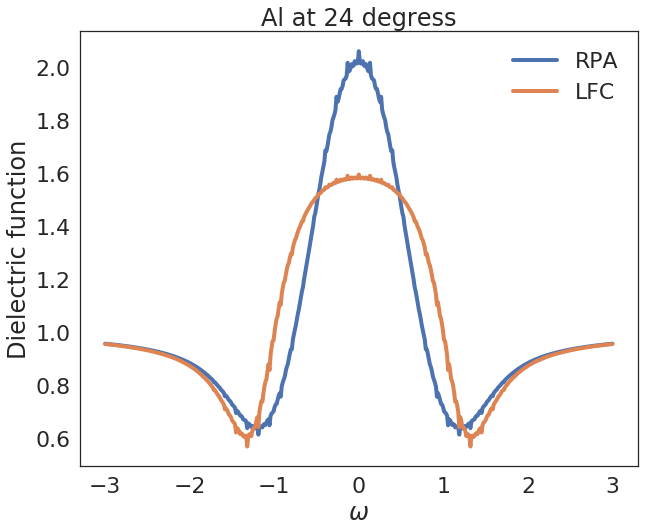

In [17]:
# Plot EPSLind
figure(figsize=[10,8])
sns.set(font_scale=2)
sns.set_style("white")
cmap = sns.color_palette('deep')
ax1 = plt.subplot(1,1,1)
ax1.set_title('Al at 24 degress')
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'Dielectric function')

xmin = 0.0
xmax = 2.0
ymin = -.5
ymax = 3.6
#xlim(xmin,xmax)
#ylim(ymin,ymax)

ax1.plot(raOmega, raEpsLind_Al,  linestyle='-', label=r'RPA', c=cmap[0], linewidth=4)
ax1.plot(raOmega, raEpsGPIMC_Al, linestyle='-', label=r'LFC', c=cmap[1], linewidth=4)

ax1.legend(frameon=False)

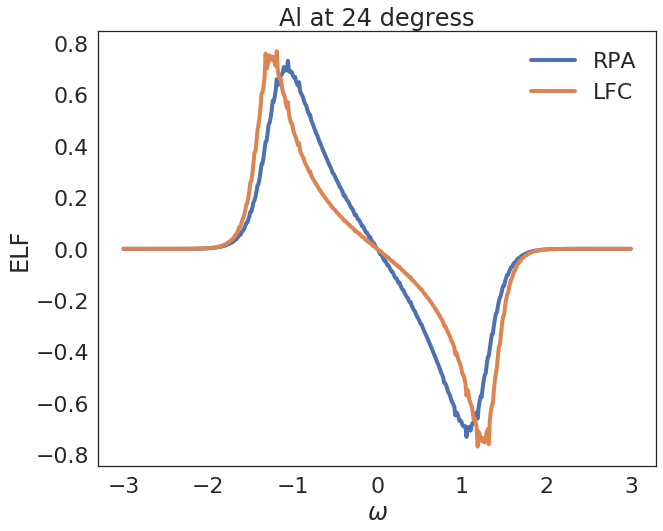

In [18]:
# Plot ELFLind
figure(figsize=[10,8])
sns.set(font_scale=2)
sns.set_style("white")
cmap = sns.color_palette('deep')
ax1 = plt.subplot(1,1,1)
ax1.set_title('Al at 24 degress')
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'ELF')

xmin = 0.0
xmax = 2.0
ymin = -.5
ymax = 3.6
#xlim(xmin,xmax)
#ylim(ymin,ymax)

ax1.plot(raOmega, raELFLind_Al,  linestyle='-', label=r'RPA', c=cmap[0], linewidth=4)
ax1.plot(raOmega, raELFGPIMC_Al, linestyle='-', label=r'LFC', c=cmap[1], linewidth=4)

ax1.legend(frameon=False)

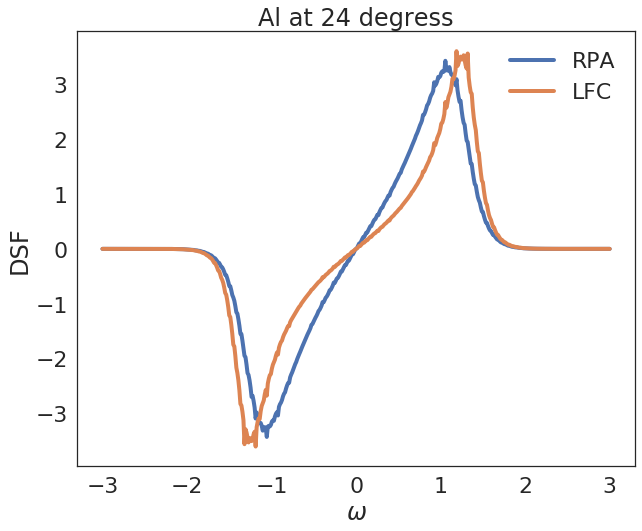

In [19]:
# Plot DSFLind
figure(figsize=[10,8])
sns.set(font_scale=2)
sns.set_style("white")
cmap = sns.color_palette('deep')
ax1 = plt.subplot(1,1,1)
ax1.set_title('Al at 24 degress')
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'DSF')

xmin = 0.0
xmax = 2.0
ymin = -.5
ymax = 3.6
#xlim(xmin,xmax)
#ylim(ymin,ymax)

ax1.plot(raOmega,raDSFLind_Al,  linestyle='-', label=r'RPA', c=cmap[0], linewidth=4)
ax1.plot(raOmega,raDSFGPIMC_Al, linestyle='-', label=r'LFC', c=cmap[1], linewidth=4)
#ax1.plot(Omega_LRTDDFT, DSF_LRTDDFT,  linestyle='-', label=r'LR-TDDFT', c=cmap[2], linewidth=4)

ax1.legend(frameon=False)

Energy of peak:  7981.866867076511


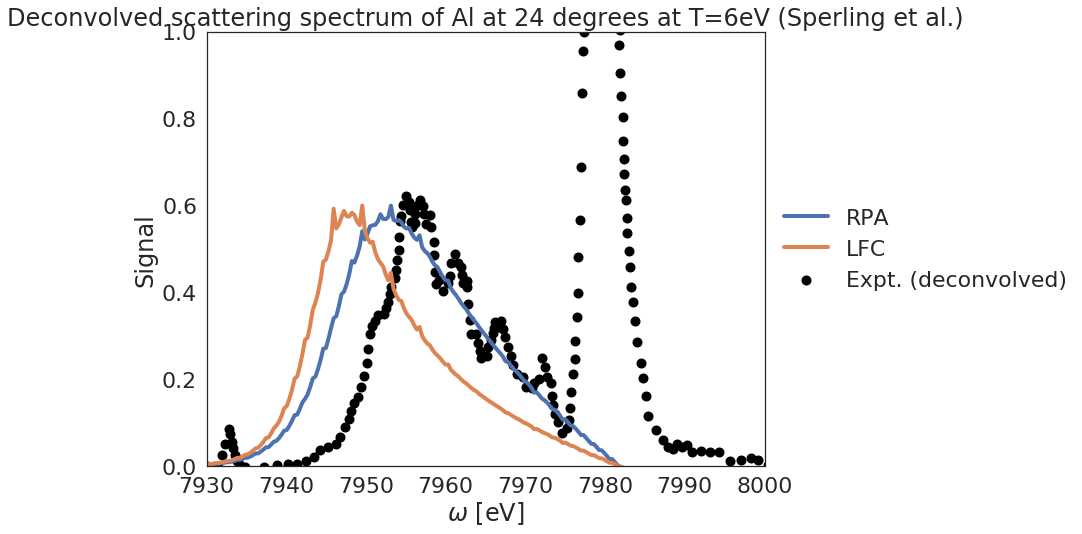

In [20]:
# Load data
filepath = './'
# Deconvolved scattering spectrum at 24 degrees
Omega_Al_deconvolved_Sperling = np.loadtxt(filepath+'Al_deconvolved.csv', delimiter=',', skiprows=0, usecols={0})
Al_deconvolved_Sperling = np.loadtxt(filepath+'Al_deconvolved.csv', delimiter=',', skiprows=0, usecols={1})

# Determine peak energy of experimental signal 
peakE = Omega_Al_deconvolved_Sperling[argmax(Al_deconvolved_Sperling)]
print('Energy of peak: ', peakE)

# Plot collision frequencies
figure(figsize=[10,8])
sns.set(font_scale=2)
sns.set_style("white")
ax1 = plt.subplot(1,1,1)
#ax1.grid()
ax1.set_title('Deconvolved scattering spectrum of Al at 24 degrees at T=6eV (Sperling et al.)')
ax1.set_xlabel(r'$\omega$ [eV]')
ax1.set_ylabel(r'Signal')

xmin = 7930
xmax = 8000
ymin = 0
ymax = 1
xlim(xmin,xmax)
ylim(ymin,ymax)

# Experiment
ax1.scatter(Omega_Al_deconvolved_Sperling, Al_deconvolved_Sperling, linewidth=4, linestyle='-', color='black', alpha=1.0, label=r'Expt. (deconvolved)')

# RPA Lindhard
ax1.plot(peakE-raOmegaeV, raDSFLind_Al/max(raDSFLind_Al)*0.6,   linestyle='-', label=r'RPA', c=cmap[0], linewidth=4)

# RPA Lindhard with LFC
ax1.plot(peakE-raOmegaeV, raDSFGPIMC_Al/max(raDSFGPIMC_Al)*0.6, linestyle='-', label=r'LFC', c=cmap[1], linewidth=4)


# Legend
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Save the figure
#filepath = '../figures/'
plt.savefig('DSF-Al-24deg-T6eV_RPA-LFC.pdf', bbox_inches='tight', pad_inches=0.02, dpi=150)

# Scratchpad